# Kink-tearing version novembre 2021 - test 2


<font color='red'>[Dernière mise à jour : 01/12/2021] </font>
- Tracés des profils de courant [<font color='blue'> ajouter légendes </font>]
- Tracés de la solution tearing [<font color='blue'> ajouter légendes et tangentes </font>]
- Calcul du saut de pente $\Delta'$, puis du taux de croissance $\gamma$
- Tracés des abaques [<font color='blue'> en cours </font>]
- <font color='blue'>ajouter le calcul du $\Delta'$ avec le fit asymptotique</font>

In [131]:
import numpy as np 
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc

## Déclaration des variables

On définit ici les variables utiles : 

$N$ le nombre de points de la simulation, $r_{min}$ le premier point considéré à l'intérieur
,$r_{max}$ le dernier point considéré à l'extérieur
,$n$ le nombre d'onde poloïdal, $m$ le nombre d'onde toroïdal, $B_0$, $R_0$, $q_s = \frac{m}{n}$ le facteur de sécurité sur la surface de résonance.

In [132]:
N = 1000
rmin = 0.000001
rmax = 1
step = rmax/N
r0 = 0.5
psi0 = 1.
B0 = 1.
R0 = 1.
mu0 = 4*np.pi*10E-7
j0prime = -1
q0 = (-2*B0)/(mu0*j0prime*r0*R0)
n = 1.
m = 2.
qs = m/n
#vecteur des positions
v_r0 = np.linspace(rmin, rmax, N)

## Profil à l'équilibre 

Dans cette section, on indroduit une fonction profil qui trace les valeurs à l'équilibre pour les profils de courant, facteur de sécurité et leurs dérivées. 

On commence par introduire la fonction wess qui calcule pour une position radiale la valeur du facteur de sécurité $q(r)$associée selon un profil de courant de type Wesson. Les paramètres sont $q_a$ et $\nu$.

In [133]:
def wess(r, qa, nu):
    return qa*r**2/(1-(1 - r**2)**(nu+1))

La fonction profil sert ensuite à calculer les valeurs à l'équilibre pour un type de profil de courant. Nous y avons intégré 2 types pour le moment : 
- profil de Wesson, comme vu plus haut 
- profil type "step function" qui possède une solution analytique et peut donc être utile pour tester le présent programme


In [155]:
def profil(type, param):
    '''La fonction profil donne les valeurs de v_r, v_q, v_jeq et v_djeq qui correspondent au profil équilibre.
    Pour le moment deux types possibles : 
    - step (profil en step function traité dans l'exercice 5 du poly de MHD)
    - wess (profil de wesson, qui prend comme paramètres qa et nu)'''
    
    if type == 'wess': 
        qa = param[0]
        nu = param[1]
        v_q = wess(v_r0,qa,nu)
        
        #Maintenant on trouve la surface de resonnance et on change le vecteur v_r
        rs = np.interp(qs,v_q,v_r0)
        b = np.arange(rs+step/2,rmax,step)
        a = -np.arange(-(rs-step/2),-rmin,step)
        a = np.sort(a)
        v_r = np.concatenate((a,b)) #le nouveau vecteur v_r équidistant à la surface de résonnance
        v_q = wess(v_r,qa,nu)

        #On calcule jeq et djeq avec le nouveau maillage équidistant
        v_jeq = (np.gradient(v_r**2/v_q)*B0)/(mu0*R0*v_r*step)
        v_djeq = np.gradient(v_jeq)/step
        v_s = np.gradient(v_q)/(v_r*step)
        
        #Magnetic shear à la résonance 
        ss = np.interp(rs,v_r,v_s)   #Non revoir interp
        #Correction des premiers termes
        v_jeq[0] = np.interp(v_r[0],v_r[1:],v_jeq[1:])
        v_s[0] = np.interp(v_r[0],v_r[1:],v_s[1:])  
        v_djeq[1] = np.interp(v_r[1],v_r[2:],v_djeq[2:])
        v_djeq[0] = np.interp(v_r[0],v_r[2:],v_djeq[2:])
        
        return (v_r,v_q,v_s,v_jeq,v_djeq,rs,ss)

        


Donc pour la fonction profil : 

- profil[0]  vecteur position centré sur la surface de résonance
    
- profil[1]  safety factor 
    
- profil[2]  magnetic shear
    
- profil[3]  $j_{eq}(r)$
    
- profil[4] $\frac{dj_{eq}}{dr}$
    
- profil[5]  $r_s$
    
- profil[6]  $s_s$

In [136]:
def plot_pr(profil): 
    ''' Trace q, j_eq, d_jeq pour un profil de courant donné, avec surface de résonnance et maillage équidistant'''
    v_r = profil[0]
    v_q = profil[1]
    v_jeq = profil[3]
    v_djeq = profil[4]
    v_s = profil[2]
    rs = profil[5]
    
    plt.figure()
    plt.title('Profil de q,s')
    plt.plot(v_r,v_q)
    plt.plot(v_r,v_s)
    plt.axvline(x=rs, color = 'black', linestyle = '--')
    
    plt.figure()
    plt.title('profil de jeq')
    plt.plot(v_r,v_jeq)
    plt.axvline(x=rs, color = 'black', linestyle = '--')
    
    plt.figure()
    plt.title('profil de djeq')
    plt.plot(v_r,v_djeq)
    plt.axvline(x=rs, color = 'black', linestyle = '--')


### Exemple pour un profil de Wesson test

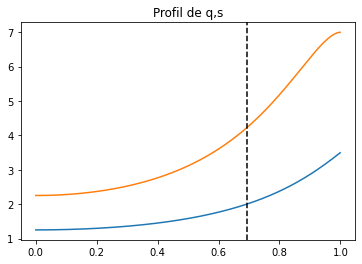

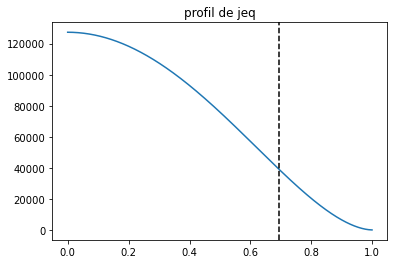

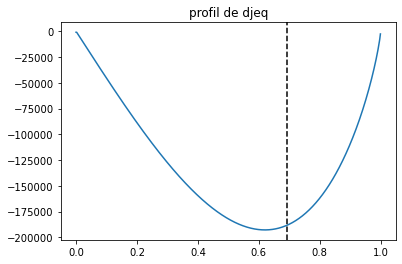

In [144]:
qa_t =3.5
nu_t = 1.8
pr_test = profil('wess',(qa_t,nu_t))
plot_pr(pr_test)

## Résolution de l'équation tearing

Maintenant qu'on a les profils d'équilibre, on est à même de résoudre l'équation kink-tearing. 

Pour cela, on utilise un schéma de Runge-Kutta d'ordre 2. On part de chaque extrémité de la section de tokamak ($r=0$ puis $r=1$) avec une pente arbitraire de 1. On raccorde au niveau de la surface de résonance à une valeur arbitraire $\psi_s = 1$. Le but est de calculer le saut de pente $\Delta'$

In [138]:
def ode2_stepRK(h,b,c,v_i):
     " solves y''+by' +c = 0 for one iteration with step h, Runge Kutta method. v_i must be of the form [y',y]"
     A = np.array([[-b,-c],[1,0]])
     return v_i + h*A.dot(v_i)+ h**2/2*(A.dot(A).dot(v_i))        

La fonction ode2_stepRK renvoie les valeurs de [y,y'] calculés pour chaque itération avec un schéma de Runge-Kutta. On l'implémente ensuite dans la fonction "solve_tear" qui construit les profils radiaux de $\psi$ et $\frac{d\psi}{dr}$



La fonction suivante solve_tear résout l'équation tearing pour un profil donné. 

In [139]:
def solve_tear(profil,param) :
    '''solve tear prend comme argument un type de profil et un paramètre param. 
    -plot : trace uniquement le graphe du profil de psi et de dpsi obtenu
    - deltap : renvoie uniquement le delta prime (pratique pour les abaques)
    - par défaut, la fonction renvoie le vecteur psi, le vecteur dpsi et la valeur de deltap'''
    

    
    #Initialisation du vecteur solution
    v_sol = np.zeros((2,N))
    v_sol[:,0] = [1,0] #ici 1 est le psi prime initial (arbitraire et on ajuste)
    
    #On prend les vecteurs du profil
    v_r = profil[0]
    v_q = profil[1]
    v_jeq = profil[3]
    v_djeq = profil[4]
    rs = profil[5]
    
    if param =='deltap'and (rs ==1 or rs ==0 ):
        return np.nan
    #Si la surface de résonance est = r<0 ou r>1.... Le problème n'est pas très intéressant.
    #On ne s'en embarasse pas trop
    #if (rs ==0 or rs ==1) and param =='deltap':
        #return np.NaN

    #Backward
    i_b = len(v_r)-1 #len(v_r)-1 : c'est le dernier point de notre vecteur position
    v_sol[:,i_b] = [1,0] #CL à l'extrémité droite
    while v_r[i_b] > rs :
        djeq = v_djeq[i_b]
        r = v_r[i_b]
        q = v_q[i_b]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1./r    
        v_i = v_sol[:,i_b]      
        v_sol[:,i_b-1] = ode2_stepRK(step,b,c,v_i)
        i_b = i_b - 1

    v_sol[0,i_b:] = - v_sol[0,i_b:] #vraies dérivées par rapport au sens de parcours r croissant donc l'opposé
    
    psi_sb = v_sol[1,i_b+1]
    v_sol[:,i_b+1:] = v_sol[:,i_b+1:]/psi_sb #raccordement du psi back 
    
    #Forward
    i_f = 0
    while v_r[i_f+1] < rs : #lorsqu'on s'intéresse à i_f on calcule le terme suivant
        djeq = v_djeq[i_f]
        r = v_r[i_f]
        q = v_q[i_f]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1/r
        v_i = v_sol[:,i_f]      
        v_sol[:,i_f+1] = ode2_stepRK(step,b,c,v_i)
        i_f = i_f +1
        
    #Raccordement de psi forward
    psi_sf = v_sol[1,i_f]
    v_sol[:,:i_f+1] = v_sol[:,:i_f+1]/psi_sf
    
    #extraction psi dpsi
    psi = v_sol[1,:]
    dpsi = v_sol[0,:]
    deltap = dpsi[i_b+1]-dpsi[i_b]
    
    if param == 'plot' :
        plt.figure()
        plt.title(r'$\psi$')
        plt.plot(v_r,psi)
        plt.axvline(x=rs, color = 'black', linestyle = '--')
        plt.show()

        plt.figure()
        plt.title(r'$\frac{d \psi}{dr}$')
        plt.plot(v_r,dpsi)
        plt.axvline(x=rs, color = 'black', linestyle = '--')
        plt.show()
        
    elif param =='deltap':
        if rs ==1 or rs ==0 : 
            return NaN
        return deltap
    
    else : 
        return (psi,dpsi,deltap)


Pour faciliter le calcul des taux de croissance ou la réalisation des abaques, on introduit la fonction deltap_w.

In [146]:
def deltap_w(qa,nu):
    '''Renvoie la valeur de delta prime pour le profil de Wesson qa nu'''
    pr = profil('wess',(qa,nu))
    return solve_tear(pr,'deltap')

### Exemple pour un profil de Wesson test

Pour le même profil que précédemment ($q_a = 3.5$, $\nu = 1.8$) on trace le profil solution. 

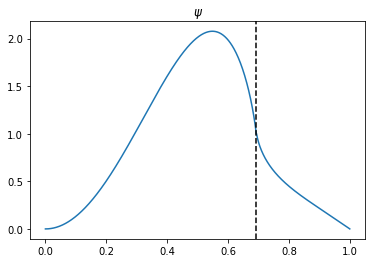

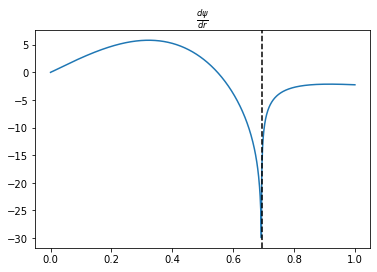

In [147]:
solve_tear(pr_test,'plot')

Et le calcul de $\Delta'$ donne : 

In [149]:
deltap_w(qa_t,nu_t)

10.337005724248236

## Taux de croissance de l'instabilité tearing

In [151]:
def rs_w(qa,nu):
    return profil('wess',(qa,nu))[5]

In [152]:
def ss_w(qa,nu):
    return profil('wess',(qa,nu))[6]

In [157]:
ss_w(3.5,1.8)

4.222704755319663

Le but est de calculer le taux de croissance de l'instabilité tearing tel que le renvoie GYSELA. Tout d'abord, nous allons tracer les abaques de $\Delta'$ qui sont à comparer avec le résultats obtenus par D. Zarzoso dans [1]

La normalisation dans GYSELA est calculée comme suit : 

$\large\frac{1}{2 \sqrt{\pi}} \times (\tilde{\Delta'}) \times \frac{\rho_\star^3}{\beta_{eq}} \sqrt{\frac{m_e}{m_p}} \sqrt{\frac{T_e}{T_0}} \frac{a}{r_s} \frac{a}{R_0} \frac{s_s}{q_s}m $

Où : 
- $s_s$ est le magnetic shear au niveau de la surface de résonance 
- $\Delta'$ est normalisée par rapport au petit rayon $a =1$ du tokamak
- $\rho_\star$ est le rayon de Larmor normalisé 
- $\beta$ est le ration entre l'énergie cinétique et l'énergie magnétique 
- $T_e$ la température électronique, prise égale à la température ionique $T_i = T_0 = T_e$ dans GYSELA
- $q_s$ le facteur de sécurité à la surface de résonance
- $r_s$ la position de la surface de résonance

In [161]:
def gamma_w(qa,nu):
    deltap = deltap_w(qa,nu)
    rs = rs_w(qa,nu)
    ss = ss_w(qa,nu)
    beta = 0.01
    Te = 1
    T0 = 1
    rho_s = 3
    me = 1
    mp = 0.001
    a = 1
    return (1/(2*np.pi)*deltap*(rho_s**3/beta)*np.sqrt(me/mp)*np.sqrt(Te/T0)*(a/rs)*(a/R0)*(ss/qs))

In [162]:
gamma_w(3.4,1.2)

478231.62081025995

## Tracé des abaques

#### Abaque pour $r_s$

Fait un peu à la main car le meshgrid classique ne fonctionnait pas

<a list of 15 text.Text objects>

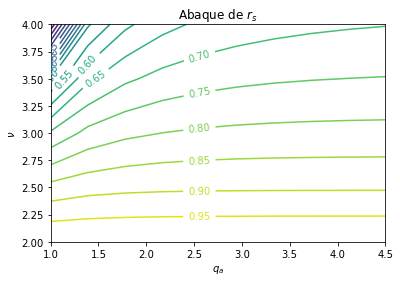

In [164]:
v_nu = np.linspace(1,4.5,10)
v_qa = np.linspace(2,4,5)
xx,yy = np.meshgrid(v_nu,v_qa)
zz =[]
for i_qa in v_qa : 
    v_rs = []
    for i_nu in v_nu : 
        rs = profil('wess',(i_qa,i_nu))[5]
        v_rs.append(rs)
    zz.append(v_rs)


plt.figure()
plt.title(r'Abaque de $r_s$')
plt.xlabel(r'$q_a$')
plt.ylabel(r'$\nu$')
graphe = plt.contour(xx,yy,zz,20)
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

C:\Users\PIERRE~1\AppData\Local\Temp/ipykernel_48252/4192227532.py:17: UserWarning: No contour levels were found within the data range.
  graphe = plt.contour(xx,yy,zz,20)


<a list of 0 text.Text objects>

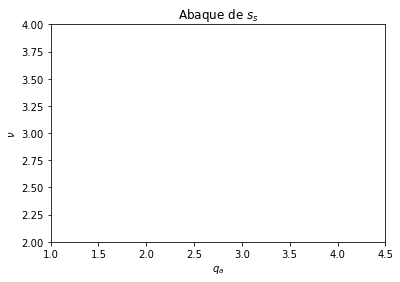

In [166]:
v_nu = np.linspace(1,4.5,10)
v_qa = np.linspace(2,4,5)
xx,yy = np.meshgrid(v_nu,v_qa)
zz =[]
for i_qa in v_qa : 
    v_rs = []
    for i_nu in v_nu : 
        ss = ss_w(i_qa,i_nu)
        v_rs.append(rs)
    zz.append(v_rs)


plt.figure()
plt.title(r'Abaque de $s_s$')
plt.xlabel(r'$q_a$')
plt.ylabel(r'$\nu$')
graphe = plt.contour(xx,yy,zz,20)
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

In [168]:
v_nu = np.linspace(1,4.5,10)
v_qa = np.linspace(2,4,5)
xx,yy = np.meshgrid(v_nu,v_qa)
zz =[]
for i_qa in v_qa : 
    v_de = []
    for i_nu in v_nu : 
        deltap = deltap_w(i_qa,i_nu)
        v_de.append(deltap)
    zz.append(v_de)


plt.figure()
plt.title(r'Abaque de $\Delta$')
plt.xlabel(r'$q_a$')
plt.ylabel(r'$\nu$')
graphe = plt.contour(xx,yy,zz,20)
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

IndexError: index -1001 is out of bounds for axis 1 with size 1000